# Application of DQN in Pacman

## Import library

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as kb
from keras import Sequential, layers
from keras.layers import Flatten, Conv2D, Dense
from collections import deque, Counter
import random
from datetime import datetime
import gym
import time
import matplotlib.pyplot as plt

## Data processing

In [2]:
color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]
    # Convert the image to greyscale
    img = img.mean(axis=2)
    # Improve image contrast
    img[img==color] = 0
    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1
    return img.reshape(88,80,1)


## Load gym

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


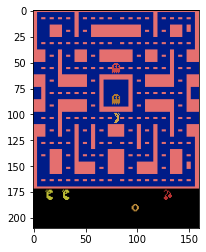

In [3]:
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()

for i in range(22):
    if i > 20:
        plt.imshow(observation)
        plt.show()
    observation, _, _, _ = env.step(1)

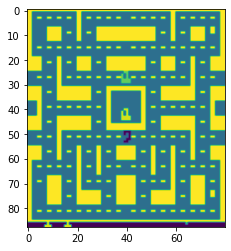

(210, 160, 3)
(88, 80)


In [5]:
#Check the processed image
obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

## Define CNN model architecture

In [6]:
def build_q_network(input_shape):    

    inputs = layers.Input(shape=input_shape)
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (8, 8), strides=4,
                            input_shape = input_shape, activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (4, 4), strides=3,
                            activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3, 3), strides=1,
                            activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dense(units = n_outputs, activation = 'linear'))
    
    print(model.summary())
    
    model.compile(optimizer = 'adam',  loss = 'mse', metrics = ['accuracy']) 
    
    return model

## Define epsilon greedy policy

In [7]:
epsilon = 0.5 
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 1000000#500000

def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() 
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action[0]

## Define memory buffer

In [8]:
buffer_len = 20000
exp_buffer = deque(maxlen=buffer_len)

In [9]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

## Hyperparameter

In [10]:
num_episodes = 2000 #800
batch_size = 48 #sample 48 entries from exp replay every time
input_shape = (4,88, 80, 1)
learning_rate = 0.001
discount_factor = 0.99

global_step = 0
copy_steps = 100 #update the mainQ NN weights
steps_train = 4 #train every 4 steps
start_steps = 2000 #only start training after 2000 steps

weights_update_steps = 100 #store weights every 100 episode

In [11]:
# Create two instances of the DQN class: a training net and a target net. 
# Target Q net is used to update the weights, 
# MainQ only performs two tasks: predicting the value at next step Q(s’, a) for MainQ to update in fitting, and copying weights from MainQ.
mainQ = build_q_network(input_shape)

targetQ = build_q_network(input_shape)
targetQ.set_weights(mainQ.get_weights())

"""
To load the weights for video playback
"""
#mainQ = tf.keras.models.load_model('mainQ_weights.h5')
#targetQ = tf.keras.models.load_model('targetQ_weights.h5')

#for checking of the inputs shape
[print(i.shape, i.dtype) for i in mainQ.inputs]
print("")
[print(o.shape, o.dtype) for o in mainQ.outputs]
print("")
[print(l.name, l.input_shape, l.dtype) for l in mainQ.layers]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 21, 19, 32)     2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 6, 6, 64)       32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 4, 64)       36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 2,174,121
Trainable params: 2,174,121
Non-trainable params: 0
______________________________________________

[None, None, None, None, None, None]

In [12]:
#keep the weights

weights_folder_path = '../model_weights/'

## Main function to run the RL algorithm

In [13]:
history = []
for i in range(num_episodes):
    done = False
    obs = env.reset()
    epoch = 0
    episodic_reward = 0
    actions_counter = Counter() 
    episodic_loss = []
    start = time.time()
    #extract 4 frames and stack them
    for i in range(4):
        obs = preprocess_observation(obs).reshape(1,88,80,1)
        if i == 0 :
            seq_obs = obs
        else:
            seq_obs = np.vstack((np.array(seq_obs),np.array(obs)))
        action = 0 #do not move in the first 4 timestep
        next_obs, reward, done, _ = env.step(action)
        obs = next_obs
        epoch += 1
        global_step += 1
        episodic_reward += reward
        
    while not done:
        #env.render() #uncomment to see the game running 
        
        # get the preprocessed game screen
        obs = preprocess_observation(obs).reshape(1,88,80,1)
        seq_obs = np.vstack((seq_obs,obs))
        seq_obs = np.delete(seq_obs,0,axis=0)
            
        # use the processed images and get the Q values for each action 
        actions = mainQ.predict(seq_obs.reshape(-1,4,88, 80, 1))
        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1
        
        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        
        # now perform the action and move to the next state, next_obs, receive reward
        next_obs, reward, done, _ = env.step(action)
        next_seq_obs = np.vstack((seq_obs,preprocess_observation(next_obs).reshape(1,88,80,1)))
        next_seq_obs = np.delete(next_seq_obs,0,axis=0)
        
        # Store in memory buffer
        exp_buffer.append([seq_obs, action, next_seq_obs, reward, done])
        
        # After certain steps, we train our Q network with samples from the experience replay buffer
        if global_step % steps_train == 0 and global_step > start_steps:
            o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

            # states
            o_obs = [x for x in o_obs]

            # next states
            o_next_obs = [x for x in o_next_obs]

            # next actions
            next_act = mainQ.predict(np.array(o_next_obs).reshape(-1,4,88, 80, 1))

            # discounted reward
            y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 
            y = np.expand_dims(y_batch, axis=-1)
            y = np.asarray(y).astype('float32')
            x=np.array(o_next_obs).reshape(-1,4,88, 80, 1)
            targetQ.fit(x=x, y=y, verbose=0)            
            targetQ_outputs = targetQ.predict(np.array(o_obs).reshape(-1,4,88, 80, 1))

        # sync main Q and target Q NN weights
        if (global_step+1) % copy_steps == 0 and global_step > start_steps:
            mainQ.set_weights(targetQ.get_weights())
            
        obs = next_obs
        epoch += 1
        global_step += 1
        episodic_reward += reward
        
    elapsed_time = time.time()-start
    history.append(episodic_reward)
    print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history), "Time:", elapsed_time)

    if len(history) % weights_update_steps == 0:
        targetQ_weights_filename = weights_folder_path + 'targetQ_{}_weights.h5'.format(len(history))
        mainQ_weights_filename = weights_folder_path + 'mainQ_{}_weights.h5'.format(len(history))
        targetQ.save(targetQ_weights_filename)
        mainQ.save(mainQ_weights_filename)
    
    #env.close()


Epochs per episode: 535 Episode Reward: 140.0 Episode number: 1 Time: 14.804836750030518
Epochs per episode: 643 Episode Reward: 290.0 Episode number: 2 Time: 17.104867935180664
Epochs per episode: 739 Episode Reward: 240.0 Episode number: 3 Time: 19.17783761024475


<ipython-input-9-4fc35f545fef>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mem = np.array(exp_buffer)[perm_batch]


Epochs per episode: 643 Episode Reward: 200.0 Episode number: 4 Time: 44.57632350921631
Epochs per episode: 597 Episode Reward: 260.0 Episode number: 5 Time: 45.483497619628906
Epochs per episode: 639 Episode Reward: 240.0 Episode number: 6 Time: 47.74157238006592
Epochs per episode: 604 Episode Reward: 210.0 Episode number: 7 Time: 48.68633008003235
Epochs per episode: 543 Episode Reward: 160.0 Episode number: 8 Time: 41.610074281692505
Epochs per episode: 625 Episode Reward: 180.0 Episode number: 9 Time: 47.0280704498291
Epochs per episode: 734 Episode Reward: 330.0 Episode number: 10 Time: 56.993353843688965
Epochs per episode: 661 Episode Reward: 240.0 Episode number: 11 Time: 51.13360142707825
Epochs per episode: 585 Episode Reward: 160.0 Episode number: 12 Time: 46.90949892997742
Epochs per episode: 656 Episode Reward: 270.0 Episode number: 13 Time: 55.36120057106018
Epochs per episode: 727 Episode Reward: 250.0 Episode number: 14 Time: 60.759016036987305
Epochs per episode: 622 

Epochs per episode: 597 Episode Reward: 240.0 Episode number: 97 Time: 73.2756826877594
Epochs per episode: 711 Episode Reward: 360.0 Episode number: 98 Time: 88.067538022995
Epochs per episode: 680 Episode Reward: 230.0 Episode number: 99 Time: 84.01429009437561
Epochs per episode: 579 Episode Reward: 140.0 Episode number: 100 Time: 71.73703908920288
Epochs per episode: 682 Episode Reward: 200.0 Episode number: 101 Time: 84.18236064910889
Epochs per episode: 650 Episode Reward: 260.0 Episode number: 102 Time: 80.66475939750671
Epochs per episode: 859 Episode Reward: 310.0 Episode number: 103 Time: 106.67108011245728
Epochs per episode: 619 Episode Reward: 220.0 Episode number: 104 Time: 75.94579935073853
Epochs per episode: 699 Episode Reward: 300.0 Episode number: 105 Time: 85.80396676063538
Epochs per episode: 675 Episode Reward: 280.0 Episode number: 106 Time: 82.655118227005
Epochs per episode: 701 Episode Reward: 230.0 Episode number: 107 Time: 85.87198185920715
Epochs per episod

Epochs per episode: 690 Episode Reward: 220.0 Episode number: 189 Time: 91.91043138504028
Epochs per episode: 1175 Episode Reward: 540.0 Episode number: 190 Time: 157.1376519203186
Epochs per episode: 676 Episode Reward: 240.0 Episode number: 191 Time: 90.1609513759613
Epochs per episode: 681 Episode Reward: 290.0 Episode number: 192 Time: 90.71494770050049
Epochs per episode: 663 Episode Reward: 300.0 Episode number: 193 Time: 88.34107637405396
Epochs per episode: 792 Episode Reward: 540.0 Episode number: 194 Time: 105.59481620788574
Epochs per episode: 625 Episode Reward: 230.0 Episode number: 195 Time: 83.73539090156555
Epochs per episode: 596 Episode Reward: 140.0 Episode number: 196 Time: 79.26433110237122
Epochs per episode: 1068 Episode Reward: 1310.0 Episode number: 197 Time: 142.34850978851318
Epochs per episode: 501 Episode Reward: 190.0 Episode number: 198 Time: 66.26289701461792
Epochs per episode: 688 Episode Reward: 250.0 Episode number: 199 Time: 91.45921277999878
Epochs

Epochs per episode: 580 Episode Reward: 180.0 Episode number: 280 Time: 77.32382774353027
Epochs per episode: 533 Episode Reward: 230.0 Episode number: 281 Time: 70.97667813301086
Epochs per episode: 607 Episode Reward: 240.0 Episode number: 282 Time: 81.28296566009521
Epochs per episode: 630 Episode Reward: 280.0 Episode number: 283 Time: 84.4936032295227
Epochs per episode: 478 Episode Reward: 180.0 Episode number: 284 Time: 64.02210688591003
Epochs per episode: 922 Episode Reward: 310.0 Episode number: 285 Time: 123.43430471420288
Epochs per episode: 729 Episode Reward: 270.0 Episode number: 286 Time: 96.81273818016052
Epochs per episode: 615 Episode Reward: 250.0 Episode number: 287 Time: 81.64217114448547
Epochs per episode: 704 Episode Reward: 210.0 Episode number: 288 Time: 93.41610288619995
Epochs per episode: 699 Episode Reward: 250.0 Episode number: 289 Time: 92.5900342464447
Epochs per episode: 1195 Episode Reward: 540.0 Episode number: 290 Time: 159.17697668075562
Epochs pe

Epochs per episode: 785 Episode Reward: 330.0 Episode number: 371 Time: 102.32216620445251
Epochs per episode: 594 Episode Reward: 250.0 Episode number: 372 Time: 76.76929140090942
Epochs per episode: 648 Episode Reward: 260.0 Episode number: 373 Time: 83.96237397193909
Epochs per episode: 751 Episode Reward: 350.0 Episode number: 374 Time: 97.80217862129211
Epochs per episode: 569 Episode Reward: 250.0 Episode number: 375 Time: 73.78743886947632
Epochs per episode: 681 Episode Reward: 250.0 Episode number: 376 Time: 89.16947364807129
Epochs per episode: 593 Episode Reward: 240.0 Episode number: 377 Time: 77.3982994556427
Epochs per episode: 543 Episode Reward: 240.0 Episode number: 378 Time: 70.24335145950317
Epochs per episode: 563 Episode Reward: 190.0 Episode number: 379 Time: 72.97969722747803
Epochs per episode: 720 Episode Reward: 280.0 Episode number: 380 Time: 93.47109508514404
Epochs per episode: 688 Episode Reward: 300.0 Episode number: 381 Time: 89.30937600135803
Epochs per

Epochs per episode: 622 Episode Reward: 270.0 Episode number: 462 Time: 79.59779667854309
Epochs per episode: 728 Episode Reward: 420.0 Episode number: 463 Time: 94.13245368003845
Epochs per episode: 535 Episode Reward: 150.0 Episode number: 464 Time: 68.23367524147034
Epochs per episode: 659 Episode Reward: 490.0 Episode number: 465 Time: 84.19085574150085
Epochs per episode: 881 Episode Reward: 620.0 Episode number: 466 Time: 112.56995797157288
Epochs per episode: 1222 Episode Reward: 740.0 Episode number: 467 Time: 156.5543611049652
Epochs per episode: 593 Episode Reward: 280.0 Episode number: 468 Time: 75.65826630592346
Epochs per episode: 658 Episode Reward: 250.0 Episode number: 469 Time: 83.97264790534973
Epochs per episode: 749 Episode Reward: 910.0 Episode number: 470 Time: 96.39676761627197
Epochs per episode: 928 Episode Reward: 570.0 Episode number: 471 Time: 119.35535955429077
Epochs per episode: 691 Episode Reward: 260.0 Episode number: 472 Time: 89.19078660011292
Epochs 

Epochs per episode: 667 Episode Reward: 240.0 Episode number: 553 Time: 140.27299237251282
Epochs per episode: 439 Episode Reward: 130.0 Episode number: 554 Time: 90.2828426361084
Epochs per episode: 452 Episode Reward: 140.0 Episode number: 555 Time: 94.45697593688965
Epochs per episode: 541 Episode Reward: 240.0 Episode number: 556 Time: 110.68127036094666
Epochs per episode: 638 Episode Reward: 430.0 Episode number: 557 Time: 130.98313403129578
Epochs per episode: 756 Episode Reward: 450.0 Episode number: 558 Time: 156.1855173110962
Epochs per episode: 967 Episode Reward: 680.0 Episode number: 559 Time: 199.6370918750763
Epochs per episode: 789 Episode Reward: 1190.0 Episode number: 560 Time: 162.07210779190063
Epochs per episode: 625 Episode Reward: 310.0 Episode number: 561 Time: 127.72968769073486
Epochs per episode: 770 Episode Reward: 300.0 Episode number: 562 Time: 159.68410062789917
Epochs per episode: 561 Episode Reward: 260.0 Episode number: 563 Time: 117.14911484718323
Epo

Epochs per episode: 1024 Episode Reward: 710.0 Episode number: 644 Time: 133.83042740821838
Epochs per episode: 840 Episode Reward: 680.0 Episode number: 645 Time: 109.56101512908936
Epochs per episode: 616 Episode Reward: 270.0 Episode number: 646 Time: 80.1130485534668
Epochs per episode: 835 Episode Reward: 690.0 Episode number: 647 Time: 108.72996997833252
Epochs per episode: 1172 Episode Reward: 840.0 Episode number: 648 Time: 152.1176836490631
Epochs per episode: 1342 Episode Reward: 950.0 Episode number: 649 Time: 173.95615458488464
Epochs per episode: 861 Episode Reward: 380.0 Episode number: 650 Time: 110.90839743614197
Epochs per episode: 1080 Episode Reward: 540.0 Episode number: 651 Time: 139.66987252235413
Epochs per episode: 751 Episode Reward: 350.0 Episode number: 652 Time: 97.31685066223145
Epochs per episode: 754 Episode Reward: 370.0 Episode number: 653 Time: 97.27546739578247
Epochs per episode: 784 Episode Reward: 420.0 Episode number: 654 Time: 101.68350148200989


Epochs per episode: 1124 Episode Reward: 1450.0 Episode number: 735 Time: 147.40066385269165
Epochs per episode: 615 Episode Reward: 420.0 Episode number: 736 Time: 79.29136896133423
Epochs per episode: 802 Episode Reward: 570.0 Episode number: 737 Time: 104.19821763038635
Epochs per episode: 651 Episode Reward: 440.0 Episode number: 738 Time: 85.01900720596313
Epochs per episode: 992 Episode Reward: 460.0 Episode number: 739 Time: 129.94334650039673
Epochs per episode: 686 Episode Reward: 370.0 Episode number: 740 Time: 89.82718062400818
Epochs per episode: 649 Episode Reward: 400.0 Episode number: 741 Time: 85.97635579109192
Epochs per episode: 850 Episode Reward: 790.0 Episode number: 742 Time: 112.22635889053345
Epochs per episode: 1274 Episode Reward: 590.0 Episode number: 743 Time: 167.3876669406891
Epochs per episode: 1216 Episode Reward: 610.0 Episode number: 744 Time: 159.33582305908203
Epochs per episode: 649 Episode Reward: 880.0 Episode number: 745 Time: 84.95597624778748
E

Epochs per episode: 772 Episode Reward: 670.0 Episode number: 826 Time: 100.81755566596985
Epochs per episode: 917 Episode Reward: 550.0 Episode number: 827 Time: 119.24504137039185
Epochs per episode: 553 Episode Reward: 280.0 Episode number: 828 Time: 71.4659526348114
Epochs per episode: 1732 Episode Reward: 1530.0 Episode number: 829 Time: 226.96311736106873
Epochs per episode: 726 Episode Reward: 300.0 Episode number: 830 Time: 94.89286613464355
Epochs per episode: 1051 Episode Reward: 960.0 Episode number: 831 Time: 145.41003012657166
Epochs per episode: 882 Episode Reward: 550.0 Episode number: 832 Time: 127.44579243659973
Epochs per episode: 918 Episode Reward: 520.0 Episode number: 833 Time: 121.89897513389587
Epochs per episode: 921 Episode Reward: 400.0 Episode number: 834 Time: 124.41308498382568
Epochs per episode: 866 Episode Reward: 540.0 Episode number: 835 Time: 112.2733850479126
Epochs per episode: 783 Episode Reward: 300.0 Episode number: 836 Time: 102.28646731376648


Epochs per episode: 938 Episode Reward: 580.0 Episode number: 917 Time: 121.3026716709137
Epochs per episode: 801 Episode Reward: 260.0 Episode number: 918 Time: 103.79397344589233
Epochs per episode: 1016 Episode Reward: 870.0 Episode number: 919 Time: 131.83588480949402
Epochs per episode: 677 Episode Reward: 260.0 Episode number: 920 Time: 88.44749641418457
Epochs per episode: 759 Episode Reward: 510.0 Episode number: 921 Time: 99.29558634757996
Epochs per episode: 910 Episode Reward: 530.0 Episode number: 922 Time: 118.27422308921814
Epochs per episode: 730 Episode Reward: 320.0 Episode number: 923 Time: 94.37359571456909
Epochs per episode: 790 Episode Reward: 370.0 Episode number: 924 Time: 102.57648348808289
Epochs per episode: 996 Episode Reward: 970.0 Episode number: 925 Time: 129.43475532531738
Epochs per episode: 890 Episode Reward: 440.0 Episode number: 926 Time: 115.27067017555237
Epochs per episode: 827 Episode Reward: 460.0 Episode number: 927 Time: 107.42868494987488
Ep

Epochs per episode: 841 Episode Reward: 390.0 Episode number: 1008 Time: 108.83285427093506
Epochs per episode: 1199 Episode Reward: 940.0 Episode number: 1009 Time: 155.64234685897827
Epochs per episode: 681 Episode Reward: 290.0 Episode number: 1010 Time: 87.9075379371643
Epochs per episode: 896 Episode Reward: 360.0 Episode number: 1011 Time: 115.99947357177734
Epochs per episode: 668 Episode Reward: 320.0 Episode number: 1012 Time: 86.4537832736969
Epochs per episode: 1086 Episode Reward: 610.0 Episode number: 1013 Time: 141.02114009857178
Epochs per episode: 698 Episode Reward: 310.0 Episode number: 1014 Time: 90.55989122390747
Epochs per episode: 842 Episode Reward: 440.0 Episode number: 1015 Time: 110.17319893836975
Epochs per episode: 1240 Episode Reward: 1060.0 Episode number: 1016 Time: 160.36999130249023
Epochs per episode: 588 Episode Reward: 210.0 Episode number: 1017 Time: 75.88949632644653
Epochs per episode: 984 Episode Reward: 1120.0 Episode number: 1018 Time: 127.3265

Epochs per episode: 603 Episode Reward: 450.0 Episode number: 1098 Time: 76.51290988922119
Epochs per episode: 581 Episode Reward: 150.0 Episode number: 1099 Time: 74.33374261856079
Epochs per episode: 876 Episode Reward: 690.0 Episode number: 1100 Time: 111.88282346725464
Epochs per episode: 567 Episode Reward: 390.0 Episode number: 1101 Time: 72.83653235435486
Epochs per episode: 1242 Episode Reward: 530.0 Episode number: 1102 Time: 159.03810620307922
Epochs per episode: 734 Episode Reward: 410.0 Episode number: 1103 Time: 93.19353365898132
Epochs per episode: 1010 Episode Reward: 890.0 Episode number: 1104 Time: 128.9688663482666
Epochs per episode: 935 Episode Reward: 500.0 Episode number: 1105 Time: 119.41232490539551
Epochs per episode: 563 Episode Reward: 400.0 Episode number: 1106 Time: 71.36079382896423
Epochs per episode: 1148 Episode Reward: 930.0 Episode number: 1107 Time: 146.77624988555908
Epochs per episode: 1113 Episode Reward: 1360.0 Episode number: 1108 Time: 142.6996

Epochs per episode: 916 Episode Reward: 840.0 Episode number: 1188 Time: 117.02384901046753
Epochs per episode: 709 Episode Reward: 590.0 Episode number: 1189 Time: 89.68993067741394
Epochs per episode: 508 Episode Reward: 400.0 Episode number: 1190 Time: 64.27624154090881
Epochs per episode: 884 Episode Reward: 740.0 Episode number: 1191 Time: 111.59722399711609
Epochs per episode: 973 Episode Reward: 900.0 Episode number: 1192 Time: 121.99707531929016
Epochs per episode: 958 Episode Reward: 760.0 Episode number: 1193 Time: 119.7651469707489
Epochs per episode: 995 Episode Reward: 550.0 Episode number: 1194 Time: 124.76794075965881
Epochs per episode: 702 Episode Reward: 570.0 Episode number: 1195 Time: 87.66250872612
Epochs per episode: 1136 Episode Reward: 670.0 Episode number: 1196 Time: 143.29351830482483
Epochs per episode: 831 Episode Reward: 930.0 Episode number: 1197 Time: 104.49217367172241
Epochs per episode: 567 Episode Reward: 420.0 Episode number: 1198 Time: 71.3526380062

Epochs per episode: 659 Episode Reward: 360.0 Episode number: 1278 Time: 82.31696343421936
Epochs per episode: 995 Episode Reward: 810.0 Episode number: 1279 Time: 124.90337586402893
Epochs per episode: 593 Episode Reward: 380.0 Episode number: 1280 Time: 75.01394891738892
Epochs per episode: 778 Episode Reward: 290.0 Episode number: 1281 Time: 96.83200526237488
Epochs per episode: 1135 Episode Reward: 900.0 Episode number: 1282 Time: 142.03774118423462
Epochs per episode: 727 Episode Reward: 460.0 Episode number: 1283 Time: 90.9090883731842
Epochs per episode: 844 Episode Reward: 520.0 Episode number: 1284 Time: 105.23216080665588
Epochs per episode: 609 Episode Reward: 390.0 Episode number: 1285 Time: 75.9866669178009
Epochs per episode: 906 Episode Reward: 730.0 Episode number: 1286 Time: 112.77909636497498
Epochs per episode: 1473 Episode Reward: 2200.0 Episode number: 1287 Time: 184.46811151504517
Epochs per episode: 671 Episode Reward: 330.0 Episode number: 1288 Time: 84.32965803

Epochs per episode: 1136 Episode Reward: 1320.0 Episode number: 1368 Time: 165.99047541618347
Epochs per episode: 727 Episode Reward: 330.0 Episode number: 1369 Time: 111.15658760070801
Epochs per episode: 915 Episode Reward: 640.0 Episode number: 1370 Time: 143.79653811454773
Epochs per episode: 882 Episode Reward: 550.0 Episode number: 1371 Time: 136.8551709651947
Epochs per episode: 515 Episode Reward: 190.0 Episode number: 1372 Time: 76.87414407730103
Epochs per episode: 668 Episode Reward: 430.0 Episode number: 1373 Time: 94.65726232528687
Epochs per episode: 666 Episode Reward: 170.0 Episode number: 1374 Time: 94.48010540008545
Epochs per episode: 674 Episode Reward: 290.0 Episode number: 1375 Time: 96.1815664768219
Epochs per episode: 889 Episode Reward: 360.0 Episode number: 1376 Time: 127.02695298194885
Epochs per episode: 568 Episode Reward: 430.0 Episode number: 1377 Time: 82.1055679321289
Epochs per episode: 747 Episode Reward: 320.0 Episode number: 1378 Time: 108.857519626

Epochs per episode: 880 Episode Reward: 1110.0 Episode number: 1458 Time: 113.65426397323608
Epochs per episode: 704 Episode Reward: 400.0 Episode number: 1459 Time: 90.19471287727356
Epochs per episode: 676 Episode Reward: 350.0 Episode number: 1460 Time: 87.39729166030884
Epochs per episode: 890 Episode Reward: 730.0 Episode number: 1461 Time: 114.01718950271606
Epochs per episode: 793 Episode Reward: 460.0 Episode number: 1462 Time: 106.0729627609253
Epochs per episode: 889 Episode Reward: 620.0 Episode number: 1463 Time: 116.28542184829712
Epochs per episode: 992 Episode Reward: 760.0 Episode number: 1464 Time: 128.69618368148804
Epochs per episode: 675 Episode Reward: 310.0 Episode number: 1465 Time: 86.15422677993774
Epochs per episode: 508 Episode Reward: 270.0 Episode number: 1466 Time: 65.97955965995789
Epochs per episode: 810 Episode Reward: 440.0 Episode number: 1467 Time: 106.9510612487793
Epochs per episode: 704 Episode Reward: 220.0 Episode number: 1468 Time: 86.998857975

Epochs per episode: 997 Episode Reward: 500.0 Episode number: 1548 Time: 121.45821022987366
Epochs per episode: 651 Episode Reward: 310.0 Episode number: 1549 Time: 79.45781898498535
Epochs per episode: 577 Episode Reward: 470.0 Episode number: 1550 Time: 70.30075407028198
Epochs per episode: 776 Episode Reward: 560.0 Episode number: 1551 Time: 94.98291969299316
Epochs per episode: 642 Episode Reward: 190.0 Episode number: 1552 Time: 78.532053232193
Epochs per episode: 610 Episode Reward: 320.0 Episode number: 1553 Time: 74.52488017082214
Epochs per episode: 741 Episode Reward: 480.0 Episode number: 1554 Time: 89.87564015388489
Epochs per episode: 1052 Episode Reward: 1100.0 Episode number: 1555 Time: 127.83216261863708
Epochs per episode: 751 Episode Reward: 1040.0 Episode number: 1556 Time: 90.72855019569397
Epochs per episode: 585 Episode Reward: 340.0 Episode number: 1557 Time: 70.15503430366516
Epochs per episode: 1252 Episode Reward: 630.0 Episode number: 1558 Time: 152.031545162

Epochs per episode: 669 Episode Reward: 170.0 Episode number: 1638 Time: 82.53948140144348
Epochs per episode: 716 Episode Reward: 200.0 Episode number: 1639 Time: 88.71736574172974
Epochs per episode: 823 Episode Reward: 270.0 Episode number: 1640 Time: 102.19279336929321
Epochs per episode: 635 Episode Reward: 230.0 Episode number: 1641 Time: 77.85303354263306
Epochs per episode: 755 Episode Reward: 340.0 Episode number: 1642 Time: 93.07092952728271
Epochs per episode: 447 Episode Reward: 180.0 Episode number: 1643 Time: 55.55528020858765
Epochs per episode: 525 Episode Reward: 190.0 Episode number: 1644 Time: 64.73283815383911
Epochs per episode: 585 Episode Reward: 230.0 Episode number: 1645 Time: 74.0957977771759
Epochs per episode: 575 Episode Reward: 120.0 Episode number: 1646 Time: 67.7301115989685
Epochs per episode: 664 Episode Reward: 170.0 Episode number: 1647 Time: 78.72078275680542
Epochs per episode: 975 Episode Reward: 1070.0 Episode number: 1648 Time: 115.8206250667572

Epochs per episode: 926 Episode Reward: 400.0 Episode number: 1728 Time: 107.5117301940918
Epochs per episode: 749 Episode Reward: 240.0 Episode number: 1729 Time: 87.2322564125061
Epochs per episode: 641 Episode Reward: 120.0 Episode number: 1730 Time: 74.85886812210083
Epochs per episode: 869 Episode Reward: 430.0 Episode number: 1731 Time: 101.28168654441833
Epochs per episode: 644 Episode Reward: 200.0 Episode number: 1732 Time: 75.78053903579712
Epochs per episode: 594 Episode Reward: 260.0 Episode number: 1733 Time: 68.64861965179443
Epochs per episode: 864 Episode Reward: 870.0 Episode number: 1734 Time: 100.33252739906311
Epochs per episode: 731 Episode Reward: 120.0 Episode number: 1735 Time: 85.0288622379303
Epochs per episode: 551 Episode Reward: 350.0 Episode number: 1736 Time: 64.10402464866638
Epochs per episode: 947 Episode Reward: 290.0 Episode number: 1737 Time: 109.99248790740967
Epochs per episode: 853 Episode Reward: 990.0 Episode number: 1738 Time: 98.9700043201446

Epochs per episode: 723 Episode Reward: 510.0 Episode number: 1818 Time: 83.96052384376526
Epochs per episode: 374 Episode Reward: 140.0 Episode number: 1819 Time: 43.63243317604065
Epochs per episode: 598 Episode Reward: 280.0 Episode number: 1820 Time: 68.73664379119873
Epochs per episode: 755 Episode Reward: 450.0 Episode number: 1821 Time: 87.00245547294617
Epochs per episode: 470 Episode Reward: 270.0 Episode number: 1822 Time: 53.48564386367798
Epochs per episode: 611 Episode Reward: 340.0 Episode number: 1823 Time: 70.07219672203064
Epochs per episode: 711 Episode Reward: 400.0 Episode number: 1824 Time: 81.7731282711029
Epochs per episode: 943 Episode Reward: 430.0 Episode number: 1825 Time: 108.60919499397278
Epochs per episode: 759 Episode Reward: 270.0 Episode number: 1826 Time: 88.18576860427856
Epochs per episode: 513 Episode Reward: 290.0 Episode number: 1827 Time: 58.99643850326538
Epochs per episode: 631 Episode Reward: 390.0 Episode number: 1828 Time: 73.0711727142334


Epochs per episode: 495 Episode Reward: 280.0 Episode number: 1908 Time: 56.186795711517334
Epochs per episode: 773 Episode Reward: 420.0 Episode number: 1909 Time: 88.58307218551636
Epochs per episode: 1143 Episode Reward: 830.0 Episode number: 1910 Time: 129.39461946487427
Epochs per episode: 788 Episode Reward: 280.0 Episode number: 1911 Time: 88.66990113258362
Epochs per episode: 939 Episode Reward: 760.0 Episode number: 1912 Time: 105.73391699790955
Epochs per episode: 530 Episode Reward: 320.0 Episode number: 1913 Time: 59.489495038986206
Epochs per episode: 549 Episode Reward: 190.0 Episode number: 1914 Time: 61.98291993141174
Epochs per episode: 579 Episode Reward: 310.0 Episode number: 1915 Time: 65.25219249725342
Epochs per episode: 917 Episode Reward: 650.0 Episode number: 1916 Time: 105.41912651062012
Epochs per episode: 707 Episode Reward: 440.0 Episode number: 1917 Time: 79.67592573165894
Epochs per episode: 614 Episode Reward: 420.0 Episode number: 1918 Time: 69.67745184

Epochs per episode: 994 Episode Reward: 370.0 Episode number: 1998 Time: 111.39670825004578
Epochs per episode: 840 Episode Reward: 550.0 Episode number: 1999 Time: 93.9431402683258
Epochs per episode: 874 Episode Reward: 480.0 Episode number: 2000 Time: 97.94343900680542


## Results Visualisation

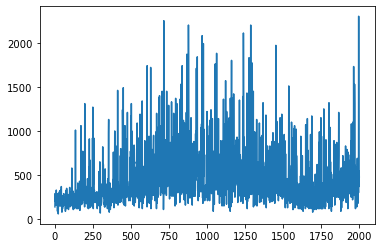

In [14]:
plt.plot(history)
plt.show()